# Leaky Integrate and Fire (LIF) Tutorial
__Authors:__ Antoine de Comite and Florence Blondiaux

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

# Tutorial Objectives
 In this tutorial, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of code to:  

- simulate the LIF neuron model

- drive the LIF neuron with external inputs, such as direct currents, Gaussian white noise, and Poisson spike trains, etc.

- study how different inputs affect the  LIF neuron's output (firing rate and spike time irregularity)

Here, we will especially emphasize identifying conditions (input statistics) under which a neuron can spike at low firing rates and in an irregular manner. The reason for focusing on this is that in most cases, neocortical neurons spike in an irregular manner.

## Reminder

A *membrane equation* and a *reset condition* define our *leaky-integrate-and-fire (LIF)* neuron:


\begin{equation*}
\tau_m \frac{du}{dt} = -(u(t)-u_{rest}) +RI(t)  \;\;\; if \; u(t)\leq \theta
\end{equation*}
\begin{equation*}
u(t) = u_{reset}  \;\;\;\;\;\;\;\;\;  otherwise
\end{equation*}


The membrane equation is an *ordinary differential equation (ODE)* that describes the time evolution of membrane potential $u(t)$ in response to synaptic input and leaking of change across the cell membrane. To find an approximation of the solution of this ODE, you can use explicit Euler integration over one time step.
Euler integration :
\begin{equation*}
\frac{dX(t)}{dt} \simeq \frac{X(t+\Delta t) - X(t)}{\Delta t}
\end{equation*}

In [122]:
#Useful functions
import numpy as np
import matplotlib.pyplot as plt

def rand_step_current(N, F = 0.03, S = 0.3):
    i_mean = 7.5e-6
    arr = np.zeros(N)
    K = int(N*F)# firing 30percent of the time
    arr[:K]  = 1
    np.random.shuffle(arr[:int(N*(1-S))]) #Random firing at the beginig of the array
    arr[int(N*(1-S)):] = 1 #Step function
    arr = arr + np.random.normal(0, 0.05,N) #add Noise
    return arr* i_mean

Implement the LIF with no fiering 
Don't take into account membrane threshold
No refractiveness period (1 eq only)

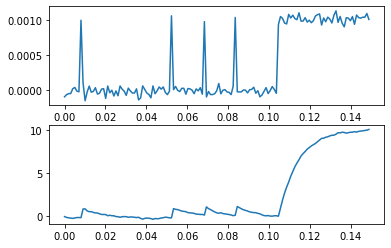

In [77]:
#Implement the integration of the current of the membrane.
#You can try with different kind of currents.
def membranePot(input_current, step_end,dt, tau= 10e-3 , urest= -60e-3 , r= 10e3): #TODO Add a description of function and remove content.
    u = np.zeros(step_end)
    u[0]=urest
    for step in range(0,step_end-1):
        u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u

#Generates a random input current
t_max = 150e-3   # second
dt = 1e-3        # second
step_end = int(t_max / dt) - 1
input_current = rand_step_current(step_end)


u = membranePot(input_current, step_end, dt)
t_range = np.linspace(0, t_max, num=step_end, endpoint=False)

fig, axs = plt.subplots(2) #Todo IMPROVE THE PLOTs
axs[0].plot(t_range,input_current)
axs[1].plot(t_range,u)

When the membrane reaches a threshold it fires add this to your implementation 

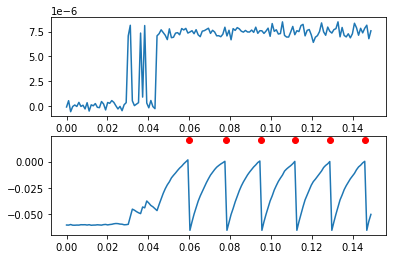

In [128]:
""" Implements a simplifed version of the LIF model, integrates the current in input following equation (1) and 
fire when the threshold reaches theta.

Input :  input_current: a vector containing the input current [A]
         step_end: the number of timestep 
         tau
         urest:  Potential of the membrane at rest [V]
         r
         ureset : Potential of the membrane after a spike
         theta: the threshold 
Output: u: the membrane potential at each time step
Output: ts: the timing at which the neurone spiked
"""
def simple_LIF(input_current, step_end,dt,  tau= 8e-3 , urest= -70e-3 , r= 10e3, ureset = -65e-3 \
               ,theta = -0.2e-3 ): #TODO Add a description of function and remove content.
    ts = []
    u = np.zeros(step_end)
    u[0]=urest
    for step in range(0,step_end-1):
        if u[step] > theta:
            u[step+1] = ureset
            ts.append((step+1)*dt)
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts

step_end = int(t_max / dt) - 1
input_current = rand_step_current(step_end,S=0.7)
u ,ts = simple_LIF(input_current, step_end, dt, tau, urest, r)
t_range = np.linspace(0, t_max, num=step_end, endpoint=False)

fig, axs = plt.subplots(2) #Todo IMPROVE THE PLOTs
axs[0].plot(t_range,input_current)
axs[1].plot(t_range,u)
axs[1].plot(ts,np.ones(len(ts))*0.02,'r.',markersize=12)

Add the refractoriness period

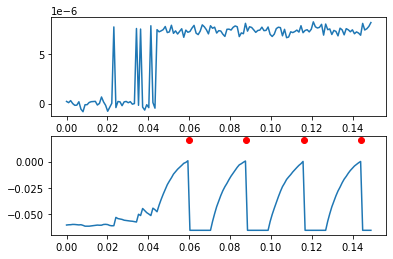

In [137]:
""" Implements the LIF model, integrates the current in input following equation (1) and 
fire when the threshold reaches theta.

Input :  input_current: a vector containing the input current [A]
         step_end: the number of timestep 
         tau
         urest:  Potential of the membrane at rest [V]
         r
         ureset : Potential of the membrane after a spike
         theta: the threshold 
Output: u: the membrane potential at each time step
        ts:
"""
def LIF(input_current, step_end,dt,  tau= 8e-3 , urest= -70e-3 , r= 10e3, ureset = -65e-3 \
               ,theta = -0.2e-3, t_ref = 10e-3 ): #TODO Add a description of function and remove content.
    u = np.zeros(step_end)
    ts = []
    S = np.zeros(step_end)
    u[0]=urest
    t_wait = 0
    for step in range(0,step_end-1):
        if u[step] > theta:
            u[step+1] = ureset
            t_wait = t_ref/dt
            ts.append((step+1)*dt)
            S[step+1] = 1
        elif t_wait >0:
            u[step +1] = ureset
            t_wait -=1
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts, S

step_end = int(t_max / dt) - 1
input_current = rand_step_current(step_end, S=0.7)
u,ts, S = LIF(input_current, step_end, dt, tau, urest, r)
t_range = np.linspace(0, t_max, num=step_end, endpoint=False)

fig, axs = plt.subplots(2) #Todo IMPROVE THE PLOTs
axs[0].plot(t_range,input_current)
axs[1].plot(t_range,u)
axs[1].plot(ts,np.ones(len(ts))*0.02,'r.',markersize=12)

## Firing rate : Reiminder 

Let ${f_i}^n_{i=1}$ represent the firing times and $S(t) := \sum_i \delta(t-t_i)$ be the spike train.

The firing rate, $p(t)$, is defined as the convolution of the spike train with a
kernel function called $\kappa(t)$: $$ \rho(t):= \kappa(t) *  S(t) = \int \kappa(t) S(t-s)ds$$

The instantaneous firing rate depends on the choice of the kernel
function !

Compute the firing rate using a rectangular kernel $ \kappa(t)= (\Delta t)^{-1} 1_{0 \leq t \leq \Delta t} $. $\rho(t)$ will therefore be the spike count in a sliding window of side $\Delta t$.

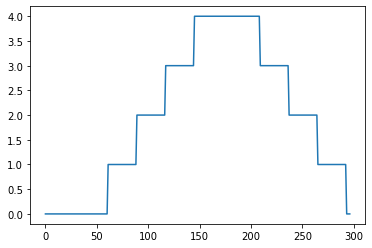

In [140]:
#Firing rate

""" 
Computes the firing rate of a neuron, needs in imput the spike train, and the kernel function. 
Output the firing rate."""
def firing_rate(k, S):
    return np.convolve(k,S)
    
Dt = 0.200
k = np.zeros(step_end)
k[1:int(Dt/dt)] = 1
plt.plot(firing_rate(k,S))


In [ ]:
#ISI intervals

In [ ]:
#Histograms to visualise

In [ ]:
#Change the input current
